# Temporal-Difference Learning

1. Implement Q-Learning with $\epsilon$-greedy action selection
2. Implement Expected Sarsa with $\epsilon$-greedy action selection
3. Investigate how these two algorithms behave on Cliff World (described on page 132 of the textbook)

The environment

<img src="cliffworld.png" alt="Drawing" style="width: 600px;"/>

The agent starts in the bottom left corner of the gridworld below and takes actions that move it in the four directions. Actions that would move the agent off of the cliff incur a reward of -100 and send the agent back to the start state. The reward for all other transitions is -1. An episode terminates when the agent reaches the bottom right corner. 

Preamble, adds virtual environment to Jupyter
>pip install ipykernel

>python -m ipykernel install --name=venv

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem

from rl_glue import RLGlue
from agent import QLearningAgent, ExpectedSarsaAgent
from environment import CliffWorld

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

## Update estimates

Q-learning
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)],
$$

derives from Bellman optimality equation for $q_*$

$$
q_*(s,a) = \mathbb{E} [ R{t+1} + \max_{a'} q_*(S{t+1},a') | S_t=s, A_t=a ]
= \sum_{s', r} p(s', r| s, a) [ r + \gamma \max_{a'} q_*(s',a')] 
$$

Expected SARSA
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + 
\gamma \sum_a \pi(a | S_{t+1}) Q(S_{t+1}, a) - Q(S_t, A_t)]
$$,

derives from Bellman equation for $q_{\pi}$

$$
q_{\pi}(s,a) = \sum_{s', r} p(s', r| s, a) ( r + \gamma \sum_{a'} \pi(a' | s') q_*(s',a')) 
$$

Using the experiment program in the cell below we now compare the agents on the Cliff World environment and plot the sum of rewards during each episode for the two agents.

100%|███████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


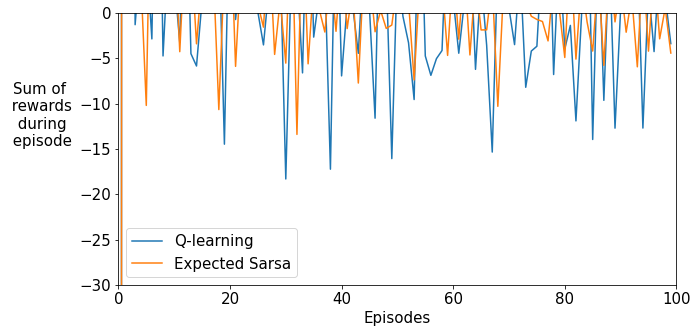

In [3]:
agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = CliffWorld
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 100 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return() - last_episode_total_reward)
            last_episode_total_reward = rl_glue.rl_return()
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# plot results
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,100)
plt.ylim(-30,0)
plt.legend()
plt.show()

To see why these two agents behave differently, let's inspect the states they visit most.

/Users/holmen1/PycharmProjects/robots/cliffworld/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  # Remove the CWD from sys.path while we load stuff.


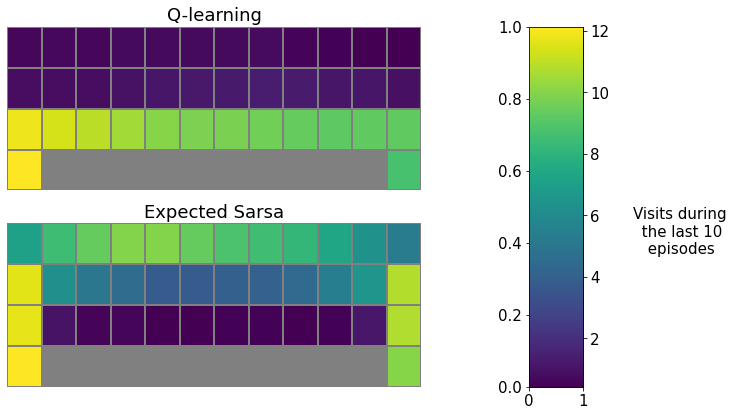

In [4]:
for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

The Q-learning agent learns the optimal policy, one that moves along the cliff and reaches the goal in as few steps as possible. However, since the agent does not follow the optimal policy and uses 𝜖
-greedy exploration, it occasionally falls off the cliff. The Expected Sarsa agent takes exploration into account and follows a safer path.

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

100%|███████████████████████████████████████████████████████████| 600/600 [05:08<00:00,  1.95it/s]


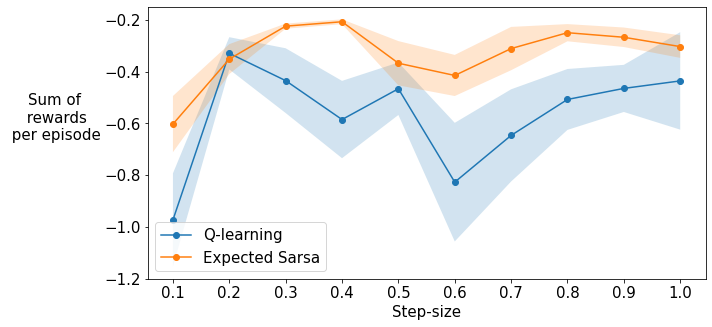

In [5]:
from itertools import product

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = CliffWorld
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()